# Food Waste Prediction Hackathon Getting Started

This notebook provides a baseline model for predicting food waste from images and ingredient information.

The goal is building a model that can help reduce food waste through better prediction and understanding of consumption patterns.

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Loading the Dataset
We first load the curated Voxel51/food-waste-dataset from the hub using fiftyone. We see a lot of fields, the necessary ones to train the model are the `image`
, `ingredient_name` and `return_quantity`.

In [2]:
%pip install fiftyone==1.7.0 > /dev/null

In [3]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub

# Load the dataset
# Note: other available arguments include 'max_samples', etc
# dataset = load_from_hub("Voxel51/food-waste-dataset", overwrite=True)
dataset = load_from_hub("hadieo/food-waste-dataset", overwrite=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


INFO:fiftyone.utils.huggingface:Downloading config file fiftyone.yml from hadieo/food-waste-dataset


Loading dataset


INFO:fiftyone.utils.huggingface:Loading dataset


Importing samples...


INFO:fiftyone.utils.data.importers:Importing samples...


 100% |█████████████████| 375/375 [235.6ms elapsed, 0s remaining, 1.8K samples/s]  


INFO:eta.core.utils: 100% |█████████████████| 375/375 [235.6ms elapsed, 0s remaining, 1.8K samples/s]  


INFO:fiftyone.utils.huggingface:Downloading 75 media files...
100%|██████████| 1/1 [00:06<00:00,  6.95s/it]


In [4]:
dataset

Name:        hadieo/food-waste-dataset
Media type:  image
Num samples: 375
Persistent:  False
Tags:        []
Sample fields:
    id:                      fiftyone.core.fields.ObjectIdField
    filepath:                fiftyone.core.fields.StringField
    tags:                    fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:              fiftyone.core.fields.DateTimeField
    last_modified_at:        fiftyone.core.fields.DateTimeField
    split:                   fiftyone.core.fields.StringField
    bonid:                   fiftyone.core.fields.IntField
    bon_id:                  fiftyone.core.fields.ListField(fiftyone.core.fields.IntField)
    article_number:          fiftyone.core.fields.ListField(fiftyone.core.fields.IntField)
    ingredient_name:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    piece_article:  

# Data preprocessing

To turn each ingredient name into a **usable numerical representation** we rely on the
[Sentence-Transformers](https://www.sbert.net/) model
`all-MiniLM-L6-v2`.  
It encodes every ingredient into a **384-dimensional embedding** that captures semantic similarity
(e.g. *“rice”* and *“basmati rice”* land close together).




In [5]:
%pip install -U sentence-transformers > /dev/null

In [6]:
import numpy as np, torch
from sentence_transformers import SentenceTransformer


MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
sbert = SentenceTransformer(MODEL_NAME)

all_ing = sorted({ing for s in dataset for ing in s["ingredient_name"]})
ing2idx = {ing: i for i, ing in enumerate(all_ing)}
idx2ing = {i: ing for ing, i in ing2idx.items()}
emb_matrix = sbert.encode(all_ing, convert_to_numpy=True)
NUM_ING = len(ing2idx)
print(ing2idx)

{'applesauce': 0, 'bread-dumplings': 1, 'breaded-fish-fillet': 2, 'brown-sauce': 3, 'carrot': 4, 'cauliflower': 5, 'chicken': 6, 'chicken-strips': 7, 'coleslaw': 8, 'cream': 9, 'diced-potatoes': 10, 'dressing-portion': 11, 'egg-spaetzle)': 12, 'gravy': 13, 'green-beans': 14, 'grilled-sausage': 15, 'ham-sausage': 16, 'iceberg-lettuce': 17, 'lentil-stew': 18, 'lentils': 19, 'light-sauce-or-white-sauce': 20, 'malt-beer-mustard-sauce': 21, 'mashed-potatoes': 22, 'mushrooms': 23, 'onion': 24, 'paprika-or-bell-pepper': 25, 'peas': 26, 'poached-meatballs': 27, 'pollock-or-coalfish': 28, 'pork-neck-roast': 29, 'potato-pancakes-or-potato-fritters': 30, 'potatoes': 31, 'red-cabbage': 32, 'rice': 33, 'roast-beef': 34, 'sauerkraut': 35, 'savoy-cabbage': 36, 'schnitzel-or-cutlet': 37, 'tomato-curry-sauce': 38, 'vegetable-based-cream': 39, 'zucchini-or-courgette': 40}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


## Dataset

This section converts the FiftyOne Dataset into a PyTorch data pipeline:

- For every dish it:
  1. resizes the photo so ResNet-18 can use it,
  2. turns each ingredient name into a 384-number embedding,
  3. writes the waste amounts into a target array.

- `collate function` – builds a batch: it stacks the photos and targets, but keeps each dish’s ingredient list separate (because dishes have different numbers of ingredients).

- `DataLoaders` – send these batches straight to the model (shuffled for training, fixed order for testing).

The important features to train the baseline model are:
- image -> PIL Image
- ingredient_name -> List[str]
- return_quantity -> List[float]

In [7]:
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

class FoodWasteTorchDataset(Dataset):
    def __init__(self, view, img_tfms):
        self.view = view
        self.ids = view.values("id")
        self.img_tfms = img_tfms

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        s = self.view[self.ids[idx]]
        img = self.img_tfms(Image.open(s.filepath).convert("RGB"))

        # ingredient embeddings (variable-length)
        emb = torch.from_numpy(
            np.stack([emb_matrix[ing2idx[i]] for i in s["ingredient_name"]])
        )

        # regression target (g of waste per ingredient)
        tgt = torch.zeros(len(ing2idx), dtype=torch.float32)
        for ing, amt in zip(s["ingredient_name"], s["return_quantity"]):
            if amt is not None:
                tgt[ing2idx[ing]] = amt
        return img, emb, tgt

def collate(batch):
    imgs, embs, tgts = zip(*batch)
    return torch.stack(imgs), list(embs), torch.stack(tgts)

tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_view = dataset.match({"split": "train"})
test_view  = dataset.match({"split": "test"})
train_dataset = FoodWasteTorchDataset(train_view, tfms)
test_dataset  = FoodWasteTorchDataset(test_view, tfms)
train_loader = DataLoader(
    train_dataset,
    batch_size=32, shuffle=True, collate_fn=collate,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32, shuffle=False, collate_fn=collate,
)

## Ingredient frequency balancing & noise

Jittering prevents the model from over-confidently memorising exact waste numbers, while frequency balancing ensures it cares about both popular and rare ingredients during training. Together they yield a model that generalises better and treats every ingredient more fairly.

- `jitter_targets`
  - Adds a small random wobble (± ε grams) to every **non-zero** waste value.
  - Keeps zeros at zero and clamps any negative results back up to 0.
  - Goal: stop the model from memorising exact numbers and make it generalise better.

- `frequency_balancing`
  - Counts how often each ingredient appears in the **training set**.
  - Converts those counts into weights:  
    `weight = 1 / log(freq + 2)`  
    &nbsp;&nbsp;• Rare ingredients → **large** weight  
    &nbsp;&nbsp;• Common ingredients → **small** weight
  - Normalises the weights so their average is 1, then moves the vector to the GPU/CPU.
  - Goal: make errors on rare ingredients matter just as much as errors on frequent ones, so the model learns to predict all ingredients—not just the popular few.

In [8]:
def jitter_targets(targets, epsilon=1.0):
    mask  = targets > 0
    noise = torch.empty_like(targets).uniform_(-epsilon, epsilon)
    jittered = targets + noise * mask.float()
    return torch.clamp(jittered, min=0.)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
freq = torch.zeros(NUM_ING, dtype=torch.long)

for sample in train_dataset:
  freq += (sample[2] > 0)

w = 1.0 / torch.log(freq.float() + 2)
w = w / w.mean()

weight_vec = w.to(device)
print("max weight:", weight_vec.max().item(),
      "min weight:", weight_vec.min().item())

cuda
max weight: 1.938257098197937 min weight: 0.30083411931991577


# Model

The multimodal regression model uses **both** the photo of a dish and the
text-based ingredient embeddings to guess how many grams of each ingredient
were left on the plate.

The model is composed of:

1. **Image branch – ResNet-18 backbone**  
   * Takes the 224 × 224 RGB photo.  
   * Outputs a 128-number vector that captures the visual appearance of the dish.

2. **Ingredient branch – 2-layer MLP**  
   * Compresses every 384-dim SBERT ingredient embedding down to 128 numbers.  
   * Keeps the full list, so we still have *L* vectors (one per ingredient in that dish).

3. **Cross-attention layer**  
   * Lets the image vector “pay attention” to the ingredient vectors.  
   * Produces a single 128-dim ingredient summary that focuses on the ingredients
     most visible in the photo.

4. **Fusion layer**  
   * Concatenates the 128-dim image vector and the 128-dim ingredient summary.  
   * Passes the 256 numbers through a small MLP + dropout → 128-dim fused vector.

5. **Regressor head**  
   * Maps the fused vector to **N** numbers, one for **each ingredient in the
     vocabulary**.  
   * A final ReLU keeps all predictions ≥ 0 (no negative grams).

In short, the network learns to look at the dish, understand which ingredients
are present, and output a per-ingredient waste estimate.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
class FoodWastePredictor(nn.Module):
    """
    Baseline: ResNet image encoder + pooled SBERT ingredient encoder
    """
    def __init__(self, *, embedding_dim: int = 512, num_ingredients: int):
        super().__init__()

        # ---------- image branch ----------
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        img_feats = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(img_feats, 128)          # → (B, 128)

        # ---------- ingredient branch ----------
        self.ing_mlp = nn.Sequential(                       # (B, 512) → (B, 128)
            nn.Linear(embedding_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True)
        )

        # ---------- fusion & head ----------
        self.fusion = nn.Sequential(
            nn.Linear(128 + 128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )
        self.q_proj = nn.Linear(128, embedding_dim, bias=False)
        self.regressor   = nn.Linear(128, num_ingredients)  # (B,N_ing)


    def forward(self, images, artikel_emb, return_total=True):
        """
        images: Tensor [B, 3, H, W]
        artikel_emb: Tensor [B, L, 512] or list of [L_i, 512] tensors
        """
        # --- image path ---
        img_feat = self.resnet(images)                      # (B,128)

        # ----- text path -----
        if isinstance(artikel_emb, list):                   # list → pad
            artikel_emb = nn.utils.rnn.pad_sequence(
                artikel_emb, batch_first=True)
        # ing_feat = self.ing_mlp(artikel_emb.mean(dim=1))    # (B,128)
        token_feat = self.ing_mlp(artikel_emb)              # (B,L,128)
        query = self.q_proj(img_feat).unsqueeze(2)
        attn_logits = (artikel_emb @ query).squeeze(2)
        attn_weights = torch.softmax(attn_logits, dim=1)
        ing_feat = (attn_weights.unsqueeze(2) * token_feat).sum(dim=1)  # (B,128)
        # ----- fuse & slot predictions -----
        combined      = torch.cat((img_feat, ing_feat), dim=1)
        fused = self.fusion(combined)                       # (B, 128)
        return F.relu(self.regressor(fused))

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)
embedding_dim = 384                         # SBERT output size
model = FoodWastePredictor(embedding_dim=embedding_dim,
                           num_ingredients=NUM_ING)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FoodWastePredictor(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

# Training

We train the model for **30 epochs** with mini-batch gradient descent, an **Adam**
optimizer (`lr = 1e-3`), and two complementary loss terms.

---

## Loss components

* **Weighted ingredient-level MSE**
  * Computes the squared error for **every ingredient** in the vocabulary.  
    ```python
    diff_sq = F.mse_loss(outputs, targets, reduction="none")   # (B, N_ing)
    loss = (diff_sq * weight_vec).mean()                       # weight rare ↗
    ```
  * `weight_vec = 1 / log(freq + 2)` — rare ingredients get larger weights,
    so their errors matter just as much as those of common staples.

* **Plate-level L1 consistency penalty**
  * Ensures the **sum** of all predicted grams matches the true total waste
    on the plate.  
    ```python
    tot_pred = outputs.sum(1)     # predicted total per dish
    tot_true = targets.sum(1)     # ground-truth total
    total_loss = loss + 1e-3 * F.l1_loss(tot_pred, tot_true)
    ```
  * Uses **L1 (absolute) error** because it is:
    * Symmetric for over- vs. under-estimates.
    * More **robust to outliers** than another MSE term.
    * Encourages sparse, targeted corrections, keeping the overall mass
      balance realistic.

> **Final objective**  
> `total_loss = ingredient_MSE_weighted + 0.001 × plate_L1`

## Target jittering

* Before each backward pass we lightly noise every non-zero gram value:
  ```python
  targets = jitter_targets(targets, epsilon=1.0)   # ±1 g
  ```

In [11]:
import torch.optim as optim
# Define Loss Function (Mean Squared Error for regression)
# With reduction='none' returns the element-wise squared error
criterion  = nn.MSELoss(reduction='none')
# Define Optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
num_epochs = 30

print("Starting training...")
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, ingredients, targets in train_loader:
        images         = images.to(device)
        ingredients    = [seq.to(device) for seq in ingredients]
        targets  = targets.to(device)
        targets = jitter_targets(targets, epsilon=1.)
        optimizer.zero_grad()
        outputs = model(images, ingredients)
        tot_pred = outputs.sum(1)
        tot_true = targets.sum(1)
        diff_sq = criterion(outputs, targets)
        loss = (diff_sq * weight_vec).mean()
        total_loss = loss + 0.001 * F.l1_loss(tot_pred, tot_true)
        total_loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished.")

Starting training...
Epoch [1/30], Loss: 36.1214
Epoch [2/30], Loss: 28.7008
Epoch [3/30], Loss: 23.2098
Epoch [4/30], Loss: 18.5685
Epoch [5/30], Loss: 16.1873
Epoch [6/30], Loss: 11.9857
Epoch [7/30], Loss: 9.1906
Epoch [8/30], Loss: 8.2737
Epoch [9/30], Loss: 6.9419
Epoch [10/30], Loss: 6.4298
Epoch [11/30], Loss: 6.1594
Epoch [12/30], Loss: 5.6905
Epoch [13/30], Loss: 5.2223
Epoch [14/30], Loss: 5.6078
Epoch [15/30], Loss: 5.6166
Epoch [16/30], Loss: 4.9629
Epoch [17/30], Loss: 5.0349
Epoch [18/30], Loss: 4.8580
Epoch [19/30], Loss: 4.7255
Epoch [20/30], Loss: 4.9137
Epoch [21/30], Loss: 4.4699
Epoch [22/30], Loss: 4.8150
Epoch [23/30], Loss: 4.6581
Epoch [24/30], Loss: 4.3994
Epoch [25/30], Loss: 4.3378
Epoch [26/30], Loss: 3.9693
Epoch [27/30], Loss: 3.7601
Epoch [28/30], Loss: 3.3259
Epoch [29/30], Loss: 3.2290
Epoch [30/30], Loss: 3.0985
Training finished.


# Metrics

After training we check how well the model performs on the **test set** with a
few easy-to-interpret numbers and plots.

---

## How we generate predictions
```python
y_true, y_pred, true_total, pred_total = get_predictions(model, test_loader, device)
```
-	Runs the model once in eval mode (no gradients).
-	Collects:
-	y_true – ground-truth grams per ingredient, shape (N, N_ing).
-	y_pred – model predictions in the same shape.
-	true_total / pred_total – per-plate totals (sum(axis=1)).

---

## Reporting

- **Ingredient-level errors**
	-	MSE – mean squared error (sensitive to big mistakes).
	-	RMSE – square-rooted MSE, back in “grams” units.
	-	MAE – mean absolute error, easier to read than MSE.
	-	R² – 1 = perfect, 0 = predicting the mean, <0 = worse than mean.
- **Plate-level checks**
  - Total-waste MAE – average absolute difference between the predicted and
true total grams on each plate.
  - Spearman ρ – rank correlation between true_total and pred_total; good
when you care about ordering plates by waste rather than exact numbers.

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import torch
from scipy.stats import spearmanr

def get_predictions(model, loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, ingredients, targets in loader:
            imgs     = imgs.to(device)
            ingredients     = [ing.to(device) for ing in ingredients]
            targets  = targets.to(device)

            preds = model(imgs, ingredients)

            y_true.append(targets.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    y_true = np.concatenate(y_true, axis=0)   # (N, num_ing)
    y_pred = np.concatenate(y_pred, axis=0)
    true_total = y_true.sum(axis=1)
    pred_total = y_pred.sum(axis=1)
    return y_true, y_pred, true_total, pred_total
def evaluate(y_true, y_pred, true_total, pred_total):
    mae_total  = np.abs(pred_total - true_total).mean()
    rho, _     = spearmanr(true_total, pred_total)

    print(f"\nTotal-waste MAE: {mae_total:.3f}   Spearman ρ: {rho:.3f}")
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

In [13]:
y_true, y_pred, true_total, pred_total = get_predictions(model, test_loader, device)
metrics = evaluate(y_true, y_pred, true_total, pred_total)
print("\nTest metrics:")
for k, v in metrics.items():
    print(f"{k:>4}: {v:.4f}")


Total-waste MAE: 36.767   Spearman ρ: 0.133

Test metrics:
 MSE: 125.3144
RMSE: 11.1944
 MAE: 3.2662
  R²: 0.4164


## Visual Check

Each point is a plate, the perfect prediction would be a diagonal line y = x

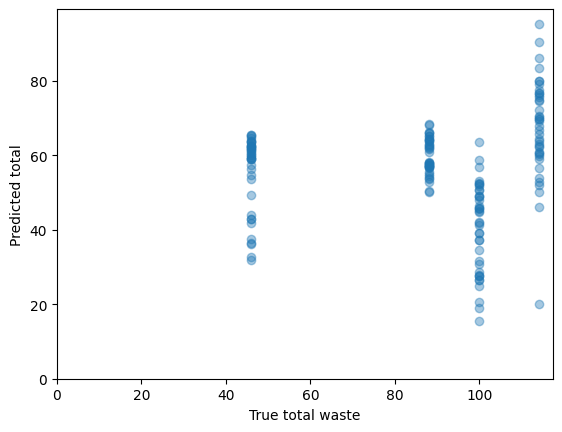

In [14]:
import matplotlib.pyplot as plt
plt.scatter(true_total, pred_total, alpha=0.4)
plt.xlabel("True total waste"); plt.ylabel("Predicted total"); plt.xlim(0); plt.ylim(0)
plt.show()

## Bias Analysis

Shows which ingredients the model over- or under-estimates on average and
by how many grams. Helpful for targeted data collection or model tweaks.

In [15]:
bias = (y_pred - y_true).mean(axis=0)          # shape (num_ing,)
worst = np.argsort(np.abs(bias))[-10:]
for i in worst[::-1]:
    print(f"{idx2ing[i]:<30} bias={bias[i]:+.2f}")

lentil-stew                    bias=-22.75
chicken                        bias=+12.54
potato-pancakes-or-potato-fritters bias=-11.50
sauerkraut                     bias=-10.87
pork-neck-roast                bias=-8.25
red-cabbage                    bias=+7.57
savoy-cabbage                  bias=-6.00
ham-sausage                    bias=-5.75
mashed-potatoes                bias=+5.50
light-sauce-or-white-sauce     bias=-4.71


In [16]:
y_pred[40]

array([ 0.       ,  0.       ,  0.       ,  8.934581 ,  0.       ,
        0.       , 12.975461 ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.784807 ,  0.       ,
        7.7134914,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       , 11.882784 ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       , 12.466713 ,  2.6875138,  0.       ,  0.       ,
        6.858057 ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ], dtype=float32)

In [17]:
y_true[40]


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., 23.,  0., 91.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.], dtype=float32)

# Things to try out

- **CLIP embeddings in place of SBERT + ResNet**
  - Use `openai/clip-vit-base-patch32` (or a food-tuned variant) to create joint image–text embeddings for each **(photo, ingredient-string)** pair.
  - Fine-tune only a small regression head; a frozen CLIP backbone often beats separate CNN + SBERT branches on small datasets.

- **Segment Anything + Grounding DINO**
  - Locate each ingredient with open-set detection (Grounding DINO) and pixel-accurate masks with SAM.
  - Feed the crop or mask-area ratio into the model so it knows **how much** of each ingredient is visible, not just that it exists.
  - Use mask area as a pseudo-label (area ≈ weight) to pre-train a mask-to-grams regressor.

- **Tackle data imbalance**
  - Use a weighted sampler / oversampling to show rare-ingredient plates more often and address the long tail.
  - Apply image-level data augmentation (flips, color jitter, cutout, etc.) to enlarge the effective dataset.

Pick **one** idea, implement it, evaluate on the test set, and document how the metrics change compared with the baseline.